In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as ssim

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
root_dir = '/content/drive/MyDrive/'

algonauts_dir = 'algonauts_2023_tutorial_data' # Path to the shortcut in your drive

reduced_images = np.load('/content/drive/MyDrive/DNNLS_PROJECT/subj01_images128.npy')



Mounted at /content/drive/


In [ ]:
# Loads all the fmri data associated to a given subject
def load_fmri_of_subject( subj, hemisphere, directory = root_dir ):
  subj = subj # Subject
  hemisphere = hemisphere # Which side of the brain
  # Listing directory
  subj = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir )
  data_dir = os.path.join(data_dir, 'subj' + subj) # subj01
  fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri') # Location the brain activation
  # Here we load the data
  if hemisphere == 'left':
    brain_activity = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
  else:
    brain_activity = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))
  return brain_activity

# Loads the data associated to a specific part of the brain (Some will be empty, it varies by subject)
def load_fmri_region_of_interest( subj, roi, hemisphere, directory = root_dir):
  subj = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir )
  data_dir = os.path.join(data_dir, 'subj' + subj) # subj01
    # Define the ROI class based on the selected ROI
  if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
      roi_class = 'prf-visualrois'
  elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
      roi_class = 'floc-bodies'
  elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
      roi_class = 'floc-faces'
  elif roi in ["OPA", "PPA", "RSC"]:
      roi_class = 'floc-places'
  elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
      roi_class = 'floc-words'
  elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
      roi_class = 'streams'

  # Loading the roi masks (To locate the activations of a given region)
  roi_class_dir = os.path.join(data_dir, 'roi_masks',
      hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
  roi_map_dir = os.path.join(data_dir, 'roi_masks',
      'mapping_'+roi_class+'.npy')
  roi_class_idx = np.load(roi_class_dir)
  roi_map = np.load(roi_map_dir, allow_pickle=True).item()
  roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
  challenge_roi = np.asarray(roi_class_idx == roi_mapping, dtype=int)

  # Selection the appropriate data
  fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri') # Location the brain activation
  # Here we load the data
  if hemisphere == 'left':
    brain_activity = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
  else:
    brain_activity = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

  fmri_roi_data = brain_activity[:,np.where(challenge_roi)[0]]

  return fmri_roi_data

# Load a particular image from a subject
def load_image_subject( subj, img, directory = root_dir):
  subj = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir )
  data_dir = os.path.join(data_dir, 'subj' + subj) # subj01
  train_img_dir  = os.path.join(data_dir, 'training_split', 'training_images')
  test_img_dir  = os.path.join(data_dir, 'test_split', 'test_images')
  train_img_list = os.listdir(train_img_dir)
  train_img_list.sort()
  test_img_list = os.listdir(test_img_dir)
  test_img_list.sort()

  img_dir = os.path.join(train_img_dir, train_img_list[img])
  train_img = Image.open(img_dir).convert('RGB') # Image library (PIL)
  return train_img

def load_reduced_image_subject( subj, img, directory = root_dir ):
  image = reduced_images[img]

  return image


def calculate_mse(original, reconstructed):
    mse = torch.mean(torch.square(original - reconstructed))
    return mse.item()

def calculate_ssim(original, reconstructed):
    # Convert tensors to numpy arrays
    original_np = original.detach().cpu().numpy().transpose(1, 2, 0)  # Remove batch dimension
    reconstructed_np = reconstructed.detach().cpu().numpy().transpose(1, 2, 0)  # Remove batch dimension

    # Calculate SSIM
    ssim_value = ssim(original_np, reconstructed_np, multichannel=True)
    return ssim_value

def img_similarity(org_img, rec_img):
    # Calculate MSE
    mse = calculate_mse(org_img, rec_img)
    # print("Mean Squared Error (MSE):", mse)

    # Calculate SSIM
    ssim_value = calculate_ssim(org_img, rec_img)
    # print("Structural Similarity Index (SSIM):", ssim_value)
    return mse , ssim_value


(9841, 20544)


<BarContainer object of 2 artists>

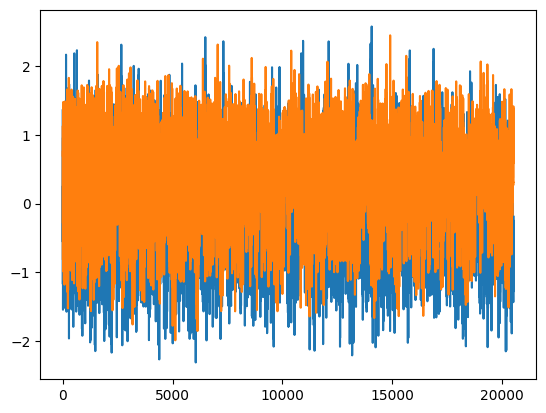

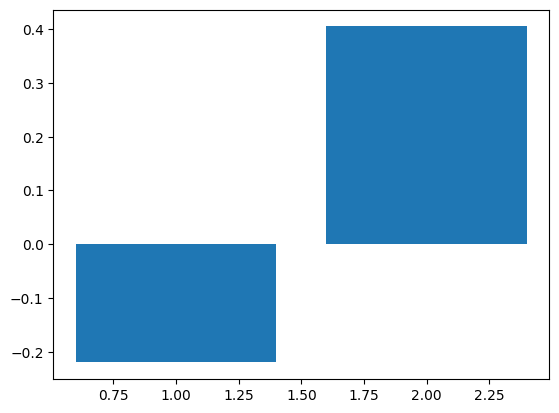

In [ ]:
# brain_activity = load_fmri_of_subject( subj = 1, hemisphere = 'right') # Images x activations

# print(brain_activity.shape) # Images x brain activty
# img1 = 143
# img2 = 247
# plt.plot(brain_activity[img1, :]) # Normalized (Z-Score)
# plt.plot(brain_activity[img2, :])

# plt.figure()
# activation1 = np.mean(brain_activity[img1, :])
# activation2 = np.mean(brain_activity[img2, :])
# plt.bar((1, 2), (activation1, activation2))

In [ ]:
# roi = "EBA"
# fmri_roi_data = load_fmri_region_of_interest( subj = 1, roi = roi, hemisphere = 'left' ) # Images x roi_data
# print(fmri_roi_data.shape)

(9841, 2837)


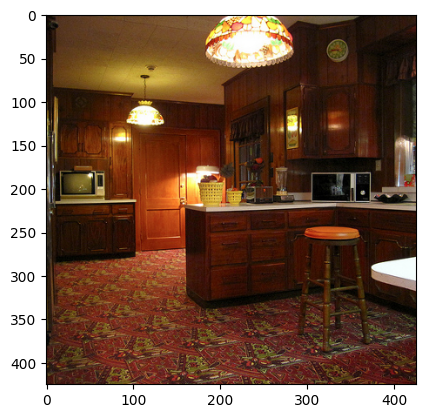

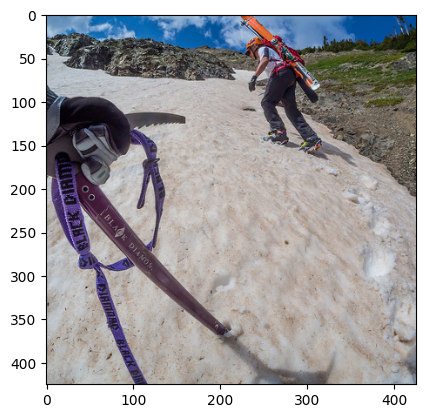

In [ ]:
# train_img = load_image_subject( subj = 1, img = img1 ) # Loading the images corresponding to the data shown before
# plt.imshow(train_img)
# plt.figure()
# train_img = load_image_subject( subj = 1, img = img2 ) # Loading the images corresponding to the data shown before
# plt.imshow(train_img)

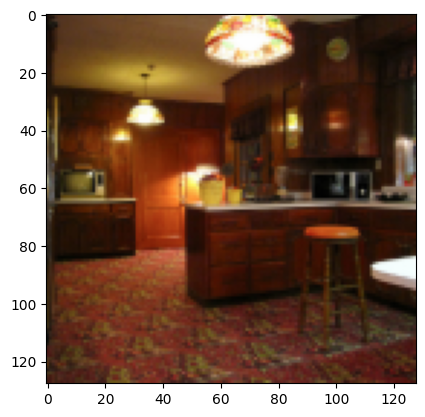

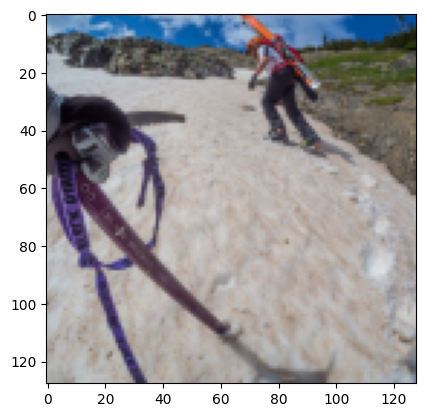

In [ ]:
# image1 = reduced_images[img1]
# image2 = reduced_images[img2]
# plt.imshow(image1)
# plt.figure()
# plt.imshow(image2)

Building a decoder

In [ ]:
# This dataset provides batches of image, brain activity, pairs
class BrainDataSet(Dataset):
  def __init__( self, subject, hemisphere, transform = None ):
    self.subject = subject # We need to select a particular object
    self.hemisphere = hemisphere
    self.fmri_data = load_fmri_of_subject( subject, hemisphere ) # Load all the data from the subjects
    self.data_len, self.num_samples = self.fmri_data.shape # Get the shape MxN
    self.transform = transform

  def __len__(self):
    return self.data_len # len is the total number of images

  def __getitem__( self, idx ):
    # Get FMRI data
    x = self.fmri_data[idx, :]
    # Obtain images
    # img = load_reduced_image_subject( subj = self.subject, img = idx ) # This is slow. If you can you should preload all images
    img = load_reduced_image_subject( subj = self.subject, img = idx )

    return self.transform(img) if self.transform else img, torch.from_numpy(x),


subject = 1 # change this to change the subject
hemisphere = 1 # change this to change the hemisphere (1 left, 2 right)
# You define to define a transform:
# 1. Convert the images to Tensors
# 2. Resize (32, 32)
# 3. Normalize
resize_normalize = transforms.Compose([
            transforms.ToPILImage(),
            # transforms.Resize((128,128)), # We downsample the images a lot. Bigger images take more time to train
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

# Create the dataset
myDataset = BrainDataSet( subject, hemisphere, resize_normalize)

In [ ]:
def showImage( ax, image, title = '' ):
  ''' This is a helper function that allows you to show the results of your training '''
  image = (image - torch.min(image))/(torch.max(image)-torch.min(image)) # image 0...1
  ax.imshow(image.permute(1,2,0)) # You need reorganize the dimension (3, H,  W) -> (H, W, 3)
  ax.set_title(title)

# Creating a data loader
# Shuffles
# Organizes in batches
train_loader = DataLoader( dataset = myDataset,
                          #  num_workers = 2, # Parallel to make it faster
                          #  prefetch_factor=16, # This is used to preload some of the data
                           batch_size = 32,
                           shuffle = True )

**Training an autoencoder**

We start by building an autoencoder network

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
        super().__init__()
        c_hid = base_channel_size  # Base channel size, e.g., 32

        self.net = nn.Sequential(
            # Starting from 128x128
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),  # 128x128 => 64x64
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),

            # Reduce to 32x32
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 64x64 => 32x32
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),

            # Reduce to 16x16
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),

            # Reduce to 8x8
            nn.Conv2d(2 * c_hid, 4 * c_hid, kernel_size=3, padding=1, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(4 * c_hid, 4 * c_hid, kernel_size=3, padding=1),
            act_fn(),

            # Reduce to 4x4
            nn.Conv2d(4 * c_hid, 4 * c_hid, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            act_fn(),

            nn.Flatten(),  # Flatten the feature map
            nn.Linear(4 * 4 * 4 * c_hid, latent_dim),  # Calculate the required number of features
        )
    def forward(self, x):
        return self.net(x)

The decoder is just the encoder inverted

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(nn.Linear(latent_dim, 2 * 16 * c_hid), act_fn())
        # self.net = nn.Sequential(
        #     nn.ConvTranspose2d(
        #         2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2
        #     ),  # 4x4 => 8x8
        #     act_fn(),
        #     nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
        #     act_fn(),
        #     nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 8x8 => 16x16
        #     act_fn(),
        #     nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
        #     act_fn(),
        #     nn.ConvTranspose2d(
        #         c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2
        #     ),  # 16x16 => 32x32
        #     # nn.Tanh(),  # If you want to bound the output
        # )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 16x16 => 32x32
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 32x32 => 64x64
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2),  # 64x64 => 128x128
            # nn.Tanh()  # If you want to bound the output, uncomment this line
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 3,
        width: int = 32,
        height: int = 32,
    ):
        super().__init__()
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)

    def forward(self, x):
        z = self.encoder(x) # Latent code
        x_hat = self.decoder(z) # Reconstruction
        return x_hat


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN = False
trainBrain = False

In [ ]:
amodel = Autoencoder(base_channel_size = 128, latent_dim = 128)

In [ ]:
amodel.encoder

Encoder(
  (net): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU(approximate='none')
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU(approximate='none')
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU(approximate='none')
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): GELU(approximate='none')
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): GELU(approximate='none')
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): GELU(approximate='none')
    (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


In [ ]:
amodel.decoder

Decoder(
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=4096, bias=True)
    (1): GELU(approximate='none')
  )
  (net): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): GELU(approximate='none')
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU(approximate='none')
    (8): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (9): GELU(approximate='none')
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): GELU(approximate='none')
    (12): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1

In [ ]:
def train_autoencoder():
  ''' Helper function that trains the autoencoder '''
  PATH = 'autoencoderMSE.pt'
  learning_rate = 1e-3
  # criterion = nn.MSELoss   #nn.CosineEmbeddingLoss()
  criterion = nn.MSELoss(reduction='mean')  # Ensures output is a single scalar

  amodel = None
  amodel = Autoencoder(base_channel_size = 128, latent_dim = 128)
  amodel = amodel.to(device)
  optimizer = torch.optim.Adam(amodel.parameters(), lr = learning_rate)
  epochs = 50

  Losses_mean = np.zeros(epochs) # We store the mean loss to plot
  Losses_std = np.zeros(epochs) # We also might want to desplay the standard deviation

  for i in range(epochs):
    current_losses = [] # We store the single losses of every epoch to average at the end

    for k, (x, y) in enumerate(train_loader):
      x = x.to(device)
      x_rec = amodel(x)
      print(x.shape, x_rec.shape)
      loss = criterion(x, x_rec)  # Are the image and the reconstruction the same?
      current_losses += [loss.item()]

      if np.mod(k, 100) == 0:
        print( f'epoch: {i}, loss: {loss.item()}' )

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    Losses_mean[i] = np.mean(np.array(current_losses))
    Losses_std[i] = np.std(np.array(current_losses))
    # Saving checkpoint
    torch.save({
              'epoch': i,
              'model_state_dict': amodel.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': Losses_mean[i],
              }, PATH) # Save checkpoint

  model_save_name = 'final_autoencoder_MSE.pt'
  path = F"/content/drive/MyDrive/{model_save_name}"
  torch.save(amodel.state_dict(), path) # Save the final weights

  return amodel, Losses_mean, Losses_std

Streaming output truncated to the last 5000 lines.
epoch: 33, loss: 0.28809839487075806
torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])
torch.Size([17, 3, 128, 128]) torch.Size([17, 3, 128, 128])
torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])
epoch: 34, loss: 0.28806576132774353
torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128]) torch

Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
      (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU(approximate='none')
      (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU(approximate='none')
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): GELU(approximate='none')
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): GELU(approximate='none')
      (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (13): GELU(approximate='none')
      (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): GELU(approximate='none')
      (16): Conv2d

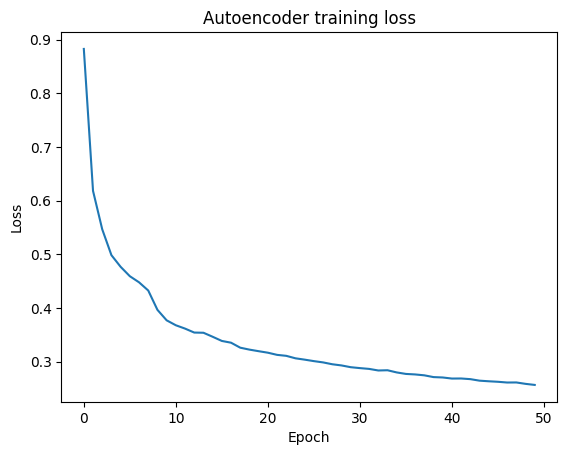

In [ ]:
if TRAIN:
  amodel, loss_mean, loss_std = train_autoencoder()
  plt.plot( loss_mean )
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Autoencoder training loss')
else:
  amodel = Autoencoder(base_channel_size = 128, latent_dim = 128) # 256 , 128
  # I provided some pretrained weights
  amodel.load_state_dict(torch.load('/content/drive/MyDrive/DNNLS_PROJECT/final_autoencoder_MSE.pt',map_location=torch.device('cpu')))

amodel.to(device)
amodel.eval()

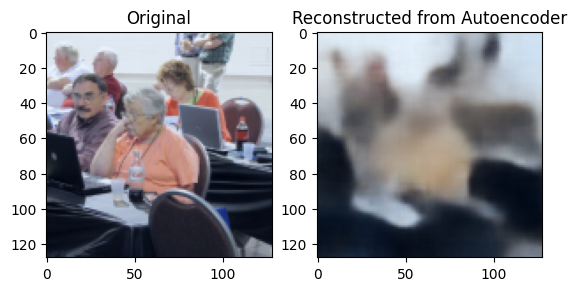

In [ ]:
# First get a sample image from the loader
image, activity = next(iter(train_loader))
# We move it to the GPU (if available)
image = image.to(device)
# We get the output of the autoencoder, which should be very similar to the image
reconstructed_image = amodel(image)
# Plot the result
fig, ax = plt.subplots(1, 2)
showImage(ax[0], image.to('cpu')[0,:, :, :], title = 'Original')
showImage(ax[1], reconstructed_image.to('cpu').detach()[0,:, :, :], title = 'Reconstructed from Autoencoder')


In [ ]:
# ***************************************************************************
# You need to define your own brain decoder
# You take the brain activity as input and the "Encoder" latent activity as output
# ****************************************************************************
class BrainDecoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
        super(BrainDecoder, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
      out = self.fc1(x)
      out = self.relu(out)
      out = self.fc2(out)
      return out

# Your code here
# The input size is the size of the vector of the brain activity


BrainDecoder(
  (fc1): Linear(in_features=20544, out_features=3000, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=3000, out_features=128, bias=True)
)

In [ ]:


image, activity = next(iter(train_loader))
size_brain_activity = activity.shape[1] # Because shape of activity is 16xSIZE_BRAIN_ACTIVTY!!!!
latent_dimension = 128 # 256 ,128


if trainBrain:

  myBrainDecoder = BrainDecoder( input_size = size_brain_activity, hidden_size = 3000, output_size = latent_dimension )
  myBrainDecoder.to(device)
  learning_rate = 1e-3
  optimizer = torch.optim.Adam(myBrainDecoder.parameters(), lr = learning_rate)
  criterion = nn.CosineEmbeddingLoss() # Try different losses
  epochs = 50

  Losses_mean = np.zeros(epochs) # We store the mean loss to plot
  Losses_std = np.zeros(epochs) # We also might want to desplay the standard deviation

  for i in range(epochs):
    current_losses = [] # We store the single losses of every epoch to average at the end

    for k, (x, brain_activity) in enumerate(train_loader):
      # First compute the output of the encoder from the image
      x = x.to(device)
      brain_activity = brain_activity.to(device)
      latent_code = amodel.encoder(x) # This is the encoder from the autoencode
      # Get the brain activity associated to that image and compute the out of the brain decoder
      y = myBrainDecoder(brain_activity)
      # Compare output to the latent code
      target = torch.ones(latent_code.size(0), dtype=torch.float, device=device)
      loss = criterion(y, latent_code, target) # Are the image and the reconstruction the same?
      current_losses += [loss.item()]

      if np.mod(k, 500) == 0:
          print( f'epoch: {i}, loss: {loss.item()}' )

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # Finished epoch
    Losses_mean[i] = np.mean(np.array(current_losses))
    Losses_std[i] = np.std(np.array(current_losses))
    torch.save({
                'epoch': i,
                'model_state_dict': myBrainDecoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': Losses_mean[i],
                }, '/content/drive/MyDrive/brain_decoder_CEL_V2.pt') # Save checkpoint
else:
  myBrainDecoder = BrainDecoder( input_size = size_brain_activity, hidden_size = 3000, output_size = latent_dimension )
  # I provided some pretrained weights
  myBrainDecoder.load_state_dict(torch.load('/content/drive/MyDrive/brain_decoder_CEL.pt',map_location=torch.device('cpu')))

myBrainDecoder.to(device)
myBrainDecoder.eval()
# TO-DO: Plot the loss (see the training of the autoencoder for ideas on how to do it)

epoch: 0, loss: 0.9806164503097534
epoch: 1, loss: 0.5172511339187622
epoch: 2, loss: 0.5340800881385803
epoch: 3, loss: 0.43384039402008057
epoch: 4, loss: 0.4025084972381592
epoch: 5, loss: 0.3216947615146637
epoch: 6, loss: 0.2946464717388153
epoch: 7, loss: 0.24490806460380554
epoch: 8, loss: 0.21827997267246246
epoch: 9, loss: 0.18296726047992706
epoch: 10, loss: 0.14601601660251617
epoch: 11, loss: 0.09943419694900513
epoch: 12, loss: 0.09906373918056488
epoch: 13, loss: 0.09472580999135971
epoch: 14, loss: 0.07359983026981354
epoch: 15, loss: 0.05941317230463028
epoch: 16, loss: 0.05303594842553139
epoch: 17, loss: 0.04492506384849548
epoch: 18, loss: 0.04332718253135681
epoch: 19, loss: 0.04229188710451126
epoch: 20, loss: 0.03720191866159439
epoch: 21, loss: 0.03763940930366516
epoch: 22, loss: 0.03324734419584274
epoch: 23, loss: 0.03406387194991112
epoch: 24, loss: 0.026463910937309265
epoch: 25, loss: 0.028885865584015846
epoch: 26, loss: 0.027518179267644882
epoch: 27, los

Text(0, 0.5, 'Loss')

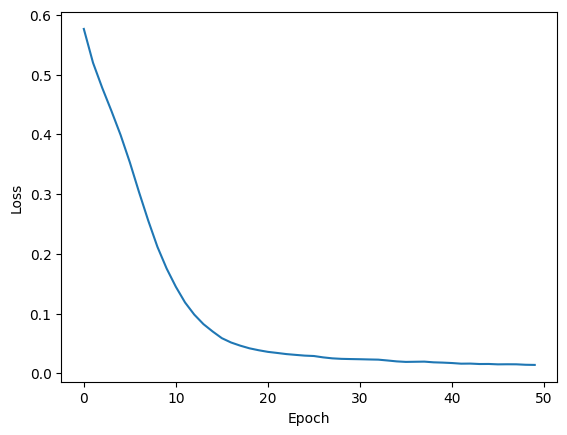

In [ ]:
# Plotting loss

plt.plot(Losses_mean)
plt.xlabel('Epoch')
plt.ylabel('Loss')

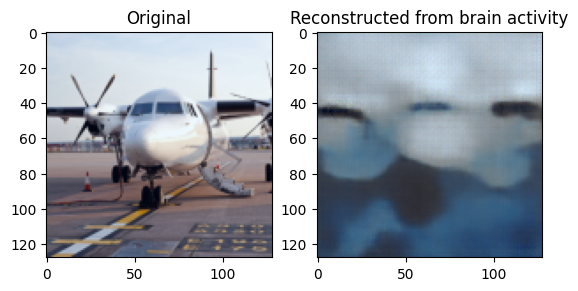

In [ ]:
# First you get the brain activity from train loader
image, brain_activity = next(iter(train_loader))
# Second you poss it through you BrainDecoder
z_brain = myBrainDecoder(brain_activity.to(device))
# Third you pass z_brain (latent code) thorugh the decoder of the autoencoder
reconstructed_image = amodel.decoder(z_brain)
reconstructed_image = reconstructed_image.detach().to('cpu')
fig, ax = plt.subplots(1,2)
showImage(ax[0], image[0, :, :, :], title = 'Original')
showImage(ax[1], reconstructed_image[0, :, :, :], 'Reconstructed from brain activity')


<ipython-input-29-3576032ff9ef>:90: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(original_np, reconstructed_np, multichannel=True)


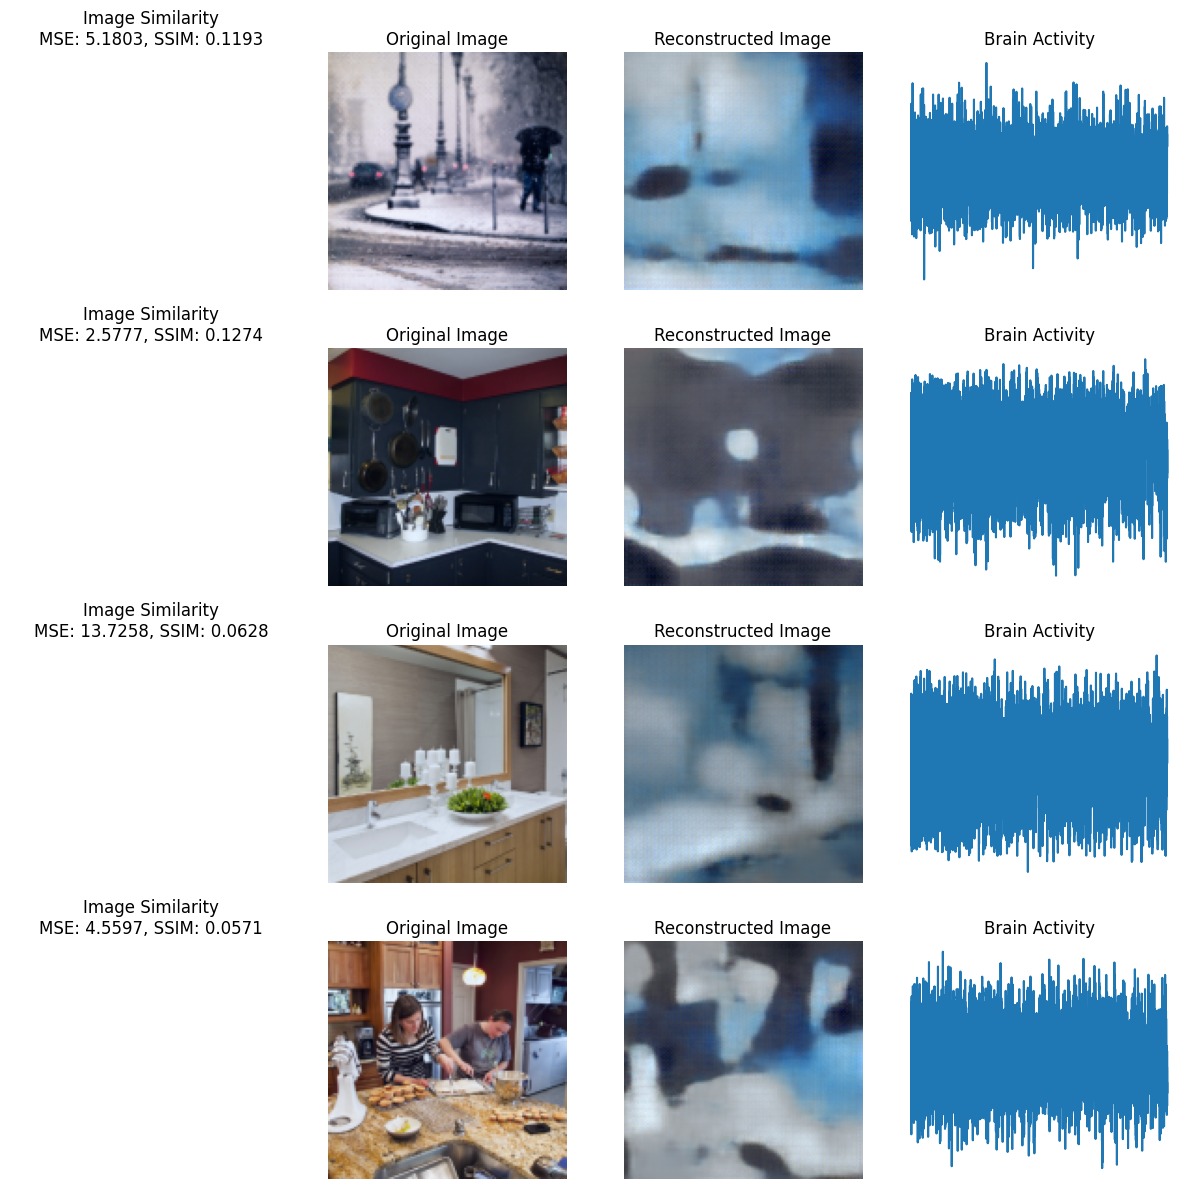

In [ ]:
image, brain_activity = next(iter(train_loader))

z_brain = myBrainDecoder(brain_activity.to(device))
# Third you pass z_brain (latent code) thorugh the decoder of the autoencoder
reconstructed_image = amodel.decoder(z_brain)
reconstructed_image = reconstructed_image.detach().to('cpu')
r = 4
fig, axs = plt.subplots(r, 4, figsize=(12, 12))
for i in range(r):
    # Show image
    mse, ssim_value = img_similarity(image[i, :, :, :], reconstructed_image[i, :, :, :])
    axs[i,0].set_title(f"Image Similarity\nMSE: {mse:.4f}, SSIM: {ssim_value:.4f}")

    axs[i, 0].axis('off')
    showImage(axs[i, 1], image[i, :, :, :], title='Original Image')
    axs[i, 1].axis('off')

    showImage(axs[i, 2], reconstructed_image[i, :, :, :], title='Reconstructed Image')
    axs[i, 2].axis('off')
    # Plot brain activity
    axs[i, 3].plot(brain_activity[i,:])
    axs[i, 3].set_title('Brain Activity')
    axs[i, 3].axis('off')


plt.tight_layout()
plt.show()

In [ ]:
# from skimage.metrics import mean_squared_error, structural_similarity
# fig, axes = plt.subplots(6, 2, figsize=(12, 16))
# axes = axes.flatten()

# for i in range(6):
#     # Convert tensors to numpy arrays and ensure they're in CPU memory and detached from gradients
#     original = image[i*2, :, :, :].cpu().detach().numpy()
#     reconstructed = reconstructed_image[i*2, :, :, :].cpu().detach().numpy()

#     # Normalize image data to 0-1 if it's not already
#     if original.max() > 1:
#         original /= 255.0
#     if reconstructed.max() > 1:
#         reconstructed /= 255.0

#     # Calculate MSE
#     mse = mean_squared_error(original, reconstructed)

#     # Check image dimensions and set win_size accordingly
#     min_dimension = min(original.shape[:2])  # Assuming images are (height, width, channels)
#     if min_dimension < 2:  # Check to avoid zero division
#         print(f"Image at index {i*2} is too small for SSIM calculation.")
#         ssim = 'N/A'
#     else:
#         win_size = max(3, min(11, min_dimension - 1))  # Ensure win_size is at least 3
#         win_size = win_size if win_size % 2 != 0 else win_size - 1
#         # Calculate SSIM, ensuring the window size is appropriate
#         ssim = structural_similarity(original, reconstructed, win_size=win_size, channel_axis=-1)

#     # Display images
#     ssim_display = f'{ssim:.2f}' if isinstance(ssim, float) else ssim
#     showImage(axes[i*2], original, f'Original - Index {i*2}')
#     showImage(axes[i*2+1], reconstructed, f'Reconstructed - Index {i*2}\nMSE: {mse:.2f}, SSIM: {ssim_display}')

#     axes[i*2].axis('off')
#     axes[i*2+1].axis('off')
#     axes[i*2].set_aspect('auto')
#     axes[i*2+1].set_aspect('auto')

# plt.tight_layout()
# plt.show()
